In [9]:
#!pip install --upgrade xlrd

  Attempting uninstall: xlrd
    Found existing installation: xlrd 0.7.1
    Uninstalling xlrd-0.7.1:
      Successfully uninstalled xlrd-0.7.1


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import re
from functools import reduce

In [52]:
# Params
data_folder = "Solar Chatbot - Energy Demand Data"
demand_col = "System Demand (Actual)"
daysofweek = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]

In [49]:
# Iterate over files and obtain file names
file_names = []

files = Path(directory).glob('*')
for file in files:
    if ".xls" in str(file):
        file_names.append(file.name)
        
# Keep only the dates
file_names = list(map(lambda x: x.replace(".xls", ""), file_names))

In [123]:
# Function to process each xls file

def process_xls(file_name):
    #Read xls and remove unnecessary bottom rows
    processed_xls = pd.read_excel(os.path.join(data_folder, ''.join([file_name, ".xls"])), 
                                  header = [4])[:48]
    #Keep only first col and selected demand cols
    processed_xls = processed_xls[[col for col in processed_xls.columns 
                                   if (demand_col in col) or (col == "Unnamed: 0")]]
    #Rename cols - "date_day" format
    new_col_names = ["Time period"] #set name of first column
    
    for day in daysofweek:
        new_col_names.append("_".join([file_name, day]))
        
    processed_xls.columns = new_col_names
    
    return processed_xls

In [124]:
# Process all files 
processed_files = []

for file_name in file_names:
    processed_file = process_xls(file_name)
    
    processed_files.append(processed_file)

In [125]:
# Merge all files
merged = reduce(lambda left, right: pd.merge(left, right, on = "Time period"), processed_files)

# 1. Chart with each line representing 1 day

No outliers observed. Pattern looks pretty consistent.

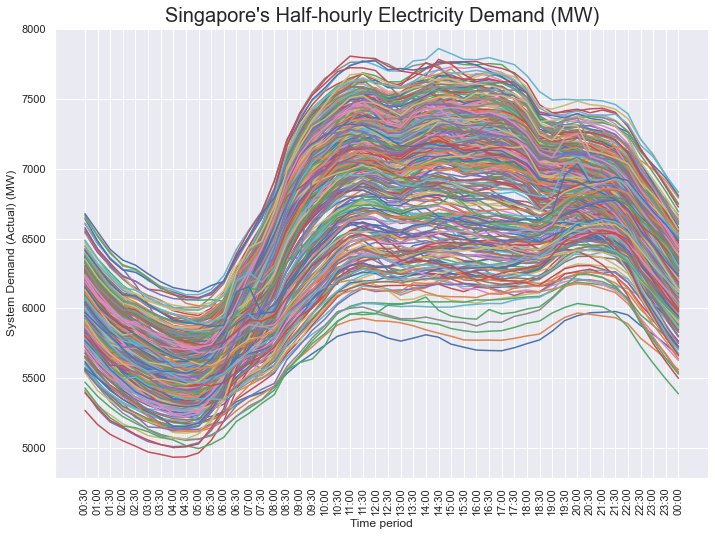

In [153]:
# Create charts - each day as 1 line
sns.set(rc={'figure.figsize':(11.7,8.27)})

for day in list(merged.columns[1:]):
    sns.lineplot(x="Time period", 
                 y=day,
                 data=merged)\
    .set(ylabel = ' '.join([demand_col, "(MW)"]))

plt.title("Singapore's Half-hourly Electricity Demand (MW)", fontsize = 20)
    
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

# 2. What you wanted!

In [178]:
# Calculate median, min and max
merged_med_range = merged.copy()

cols = [col for col in merged_med_range.columns if col != "Time period"]

merged_med_range['Median'] = merged_med_range[cols].median(axis=1)
merged_med_range['Min'] = merged_med_range[cols].min(axis=1)
merged_med_range['Max'] = merged_med_range[cols].max(axis=1)

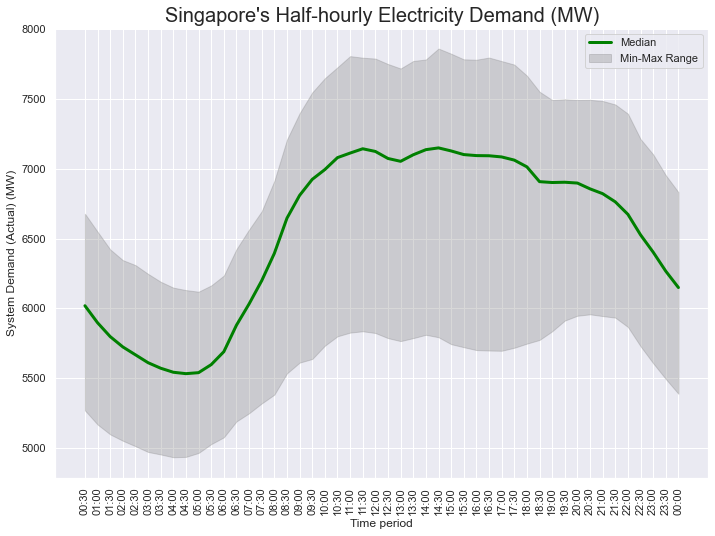

In [219]:
# Create chart - median, min, max

sns.set(rc={'figure.figsize':(11.7,8.27)})

chart_median = sns.lineplot(x="Time period", 
                 y="Median",
                 linewidth = 3,
                 label = "Median",
                 color = "green",
                 data=merged_med_range)\
    .set(ylabel = ' '.join([demand_col, "(MW)"]))

# chart_min = sns.lineplot(x="Time period", 
#                  y="Min",
#                  data=merged_med_range)\
#     .set(ylabel = ' '.join([demand_col, "(MW)"]))

# chart_max = sns.lineplot(x="Time period", 
#                  y="Max",
#                  data=merged_med_range)\
#     .set(ylabel = ' '.join([demand_col, "(MW)"]))

fill = plt.fill_between(merged_med_range['Time period'], 
                        merged_med_range['Min'], 
                        merged_med_range['Max'], 
                        color='gray',
                        alpha=0.3,
                        label = "Min-Max Range")
plt.legend()
plt.title("Singapore's Half-hourly Electricity Demand (MW)", fontsize = 20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

# 3. Pivoted dataframe - breakdown by month, day, year, day of week
Example below: Color by month.
Could also obtain median/averages by month.

In [131]:
# Pivot longer - extract year, month, day, day of week as columns
value_names = sorted(
    set([match[0] for match in merged.columns.str.findall(
        r'\d+_\w+').values if match != []])
)

merged_long = pd.melt(merged, 
        id_vars = "Time period", 
        value_vars = value_names, 
        var_name = "Date_Day", 
        value_name = "Demand (MW)", 
        ignore_index = False)

expanded_cols = merged_long['Date_Day'].str.extract('(^\d{4})(\d{2})(\d{2})_(\w+)', 
                                     expand=True)

merged_long = pd.concat([merged_long, expanded_cols], axis = 1)
merged_long = merged_long[["Time period", 
                           0, 1, 2, 3, 
                           "Demand (MW)"]]\
                        .rename(columns = {0: "Year",
                                           1: "Month",
                                           2: "Day",
                                           3: "Day of Week"})

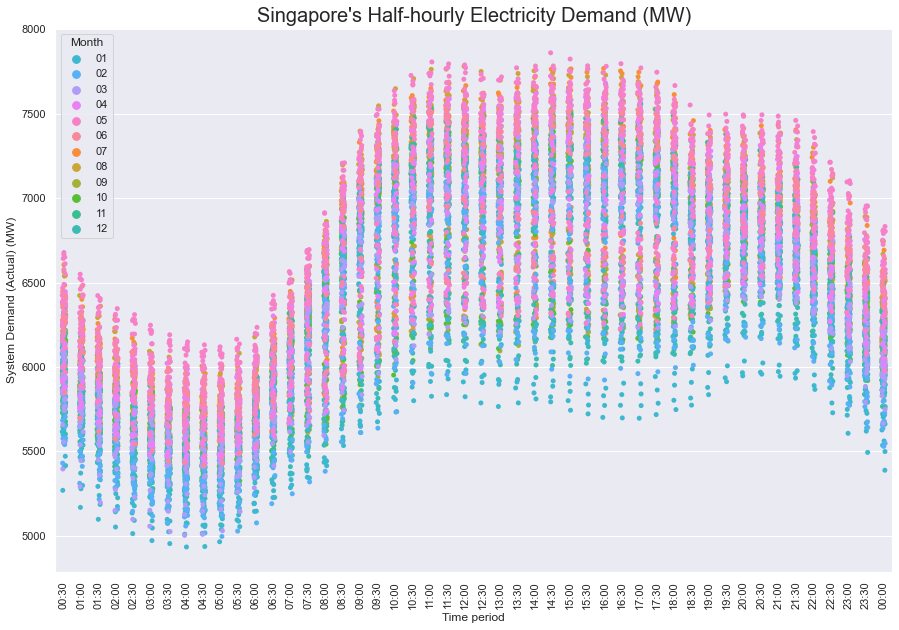

In [176]:
# Charts 
sns.set(rc={'figure.figsize':(15,10)})

chart = sns.stripplot(x="Time period", 
             y="Demand (MW)",
             hue="Month",
             data=merged_long)\
           .set(ylabel = ' '.join([demand_col, "(MW)"]))

plt.title("Singapore's Half-hourly Electricity Demand (MW)", fontsize = 20)
    
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [7, 8, 9, 10, 11,
         0, 1, 2, 3, 4, 5, 6]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], title = "Month")

plt.show()